In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
session = tf.Session(config=config)

# Image Data Augmentation In Keras

Data Aumentation（数据扩充）指的是在使用以下或者其他方法增加数据输入量。这里，我们特指图像数据。

+ 旋转 | 反射变换(Rotation/reflection): 随机旋转图像一定角度; 改变图像内容的朝向;
+ 翻转变换(flip): 沿着水平或者垂直方向翻转图像;
+ 缩放变换(zoom): 按照一定的比例放大或者缩小图像;
+ 平移变换(shift): 在图像平面上对图像以一定方式进行平移; 
+ 可以采用随机或人为定义的方式指定平移范围和平移步长, 沿水平或竖直方向进行平移. 改变图像内容的位置;
+ 尺度变换(scale): 对图像按照指定的尺度因子, 进行放大或缩小; 或者参照SIFT特征提取思想, 利用指定的尺度因子对图像滤波构造尺度空间. 改变图像内容的大小或模糊程度;
+ 对比度变换(contrast): 在图像的HSV颜色空间，改变饱和度S和V亮度分量，保持色调H不变. 对每个像素的S和V分量进行指数运算(指数因子在0.25到4之间), 增加光照变化;
+ 噪声扰动(noise): 对图像的每个像素RGB进行随机扰动, 常用的噪声模式是椒盐噪声和高斯噪声;

Data Aumentation 有很多好处，比如数据量太小了，我们用数据扩充来增加训练数据，或者通过Data Aumentation防止过拟合的问题。

在Keras中，[ImageDataGenerator](https://keras-cn.readthedocs.io/en/latest/preprocessing/image/)就是干这个事情的，特别方便。接下来，我们就聊聊ImageDataGenerator的使用方法

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


## ImageDataGenerator for Single image
ImageDataGenerator 参数很多，详见[这里](https://keras-cn.readthedocs.io/en/latest/preprocessing/image/)或者在python环境下输入`ImageDataGenerator?`，我们先看一个例子，这个例子将对一张图片进行数据扩充

In [3]:
# 指定参数
# rotation_range 旋转
# width_shift_range 左右平移
# height_shift_range 上下平移
# zoom_range 随机放大或缩小
img_generator = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3
    )

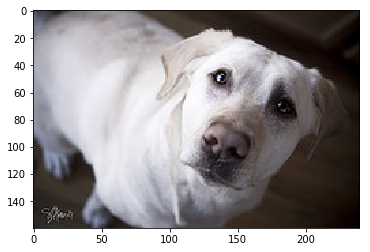

In [4]:
# 导入并显示图片
img_path = './imgs/dog.jpg'
img = image.load_img(img_path)
plt.imshow(img)

`flow()`将会返回一个生成器，这个生成器用来扩充数据，每次都会产生batch_size个样本。
因为目前我们只导入了一张图片，因此每次生成的图片都是基于这张图片而产生的，可以看到结果，旋转、位移、放大缩小，统统都有。

`flow()`可以将产生的图片进行保存，详见 [ 深度学习中的Data Augmentation方法和代码实现 ](https://absentm.github.io/2016/06/14/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E4%B8%AD%E7%9A%84Data-Augmentation%E6%96%B9%E6%B3%95%E5%92%8C%E4%BB%A3%E7%A0%81%E5%AE%9E%E7%8E%B0/)

生成图片的过程大概是这样的，并且可以一直一直一直无限循环的生成
![生成图片过程](1.JPG)

(1, 160, 240, 3)

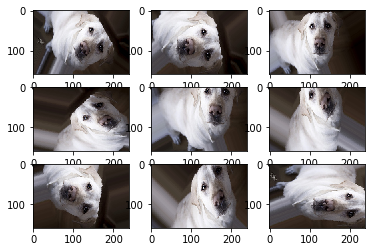

In [5]:
# 将图片转为数组
x = image.img_to_array(img)
# 扩充一个维度
x = np.expand_dims(x, axis=0)
# 生成图片
gen = img_generator.flow(x, batch_size=1)

# 显示生成的图片
plt.figure()
for i in range(3):
    for j in range(3):
        x_batch = next(gen)
        idx = (3*i) + j
        plt.subplot(3, 3, idx+1)
        plt.imshow(x_batch[0]/256)
x_batch.shape

## ImageDataGenerator for Multiple image
单张图片的数据扩展我们已经演示完毕了，但是通常情况下，我们应该是有一个不太大的训练集需要Data Aumentation或者为了防止过拟合，总之，就是对一组数据进行Data Aumentation。这里我们以cifar-10数据库做一个演示。

我们将进行一组实验，比较训练之后的测试结果：
+ cifar-10 20%数据 
+ cifar-10 20%数据 + Data Augmentation

In [6]:
from keras.datasets import cifar10
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils

In [7]:
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [8]:
def preprocess_data(x):
    x /= 255
    x -= 0.5
    x *= 2
    return x

In [9]:
# 预处理
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

# one-hot encoding
n_classes = 10
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

In [10]:
# 取 20% 的训练数据
x_train_part = x_train[:10000]
y_train_part = y_train[:10000]

print(x_train_part.shape, y_train_part.shape)

(10000, 32, 32, 3) (10000, 10)


In [11]:
# 建立一个简单的卷积神经网络
def build_model():
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), input_shape=(32,32,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(scale=False, center=False))
    
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(scale=False, center=False))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    
    return model

In [12]:
# 训练参数
batch_size = 128
epochs = 20

### cifar-10 20%数据

In [13]:
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_part, y_train_part, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 8s 844us/step - loss: 1.8075 - acc: 0.4040 - val_loss: 2.9955 - val_acc: 0.1150
Epoch 2/20
9000/9000 [==============================] - 3s 343us/step - loss: 1.2029 - acc: 0.5742 - val_loss: 3.0341 - val_acc: 0.1910
Epoch 3/20
9000/9000 [==============================] - 3s 342us/step - loss: 0.9389 - acc: 0.6690 - val_loss: 2.8508 - val_acc: 0.1580
Epoch 4/20
9000/9000 [==============================] - 3s 346us/step - loss: 0.7337 - acc: 0.7463 - val_loss: 2.8291 - val_acc: 0.1890
Epoch 5/20
9000/9000 [==============================] - 5s 526us/step - loss: 0.5569 - acc: 0.8071 - val_loss: 2.6353 - val_acc: 0.2480
Epoch 6/20
9000/9000 [==============================] - 6s 671us/step - loss: 0.4239 - acc: 0.8639 - val_loss: 2.0786 - val_acc: 0.3250
Epoch 7/20
9000/9000 [==============================] - 6s 635us/step - loss: 0.3325 - acc: 0.8980 - val_loss: 1.7977 - val_acc: 0.4100


In [14]:
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print('Loss: ', loss)
print('Accuracy: ', acc)

10000/10000 [==============================] - 4s 444us/step
Loss:  1.65560287151
Accuracy:  0.6058


经过20轮的训练之后，在训练集上已经有98%以上的准确率，但是在测试集上只有60%左右的准确率，可以说是过拟合了，主要原因就是训练集太小了，无法达到很好的效果。那么接下来我们试试经过Data Augmentation之后的准确率如何

### cifar-10 20%数据 + Data Augmentation
在进行Data Augmentation时要注意的就是：生成的数据是有意义的。比如说对于某些医疗图像，如果进行了旋转，那么这个数据就属于采样错误，是没用的了。因此，在设置生成参数时要结合实际的情况。

In [15]:
# 设置生成参数
img_generator = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2
    )

下面的代码是一种“手动”的训练方式，`Progbar`是进度条，用于显示训练进度。

另外一种“自动”的方法，请参考 [官网给的例子](https://keras-cn.readthedocs.io/en/latest/preprocessing/image/) 中 `model.fit_generator`的用法

In [16]:
from keras.utils import generic_utils

model_2 = build_model()
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation后，数据变多了，因此我们需要更的训练次数
for e in range(epochs*4):
    print('Epoch', e)
    print('Training...')
    progbar = generic_utils.Progbar(x_train_part.shape[0])
    batches = 0
    
    for x_batch, y_batch in img_generator.flow(x_train_part, y_train_part, batch_size=batch_size, shuffle=True):
        loss,train_acc = model_2.train_on_batch(x_batch, y_batch)
        batches += x_batch.shape[0]
        if batches > x_train_part.shape[0]:
            break
        progbar.add(x_batch.shape[0], values=[('train loss', loss),('train acc', train_acc)])

Epoch 0
Training...
10000/10000 [==============================] - 13s 1ms/step - train loss: 2.0455 - train acc: 0.3187
Epoch 1
Training...
10000/10000 [==============================] - 10s 1ms/step - train loss: 1.7304 - train acc: 0.3857
Epoch 2
Training...
10000/10000 [==============================] - 10s 1ms/step - train loss: 1.6195 - train acc: 0.4220
Epoch 3
Training...
10000/10000 [==============================] - 10s 1ms/step - train loss: 1.5595 - train acc: 0.4417
Epoch 4
Training...
10000/10000 [==============================] - 9s 889us/step - train loss: 1.4780 - train acc: 0.4660
Epoch 5
Training...
10000/10000 [==============================] - 9s 913us/step - train loss: 1.4523 - train acc: 0.4824
Epoch 6
Training...
10000/10000 [==============================] - 9s 942us/step - train loss: 1.3946 - train acc: 0.4992
Epoch 7
Training...
10000/10000 [==============================] - 9s 929us/step - train loss: 1.3693 - train acc: 0.5075
Epoch 8
Training...
10000/10

10000/10000 [==============================] - 9s 924us/step - train loss: 0.9107 - train acc: 0.6766
Epoch 67
Training...
10000/10000 [==============================] - 9s 942us/step - train loss: 0.9067 - train acc: 0.6833
Epoch 68
Training...
10000/10000 [==============================] - 9s 906us/step - train loss: 0.8958 - train acc: 0.6840
Epoch 69
Training...
10000/10000 [==============================] - 9s 916us/step - train loss: 0.8950 - train acc: 0.6799
Epoch 70
Training...
10000/10000 [==============================] - 9s 896us/step - train loss: 0.9128 - train acc: 0.6711
Epoch 71
Training...
10000/10000 [==============================] - 9s 890us/step - train loss: 0.8944 - train acc: 0.6848
Epoch 72
Training...
10000/10000 [==============================] - 9s 922us/step - train loss: 0.8890 - train acc: 0.6824
Epoch 73
Training...
10000/10000 [==============================] - 9s 898us/step - train loss: 0.8819 - train acc: 0.6849
Epoch 74
Training...
10000/10000 [===

In [17]:
loss, acc = model_2.evaluate(x_test, y_test, batch_size=32)
print('Loss: ', loss)
print('Accuracy: ', acc)

10000/10000 [==============================] - 5s 455us/step
Loss:  0.842164948082
Accuracy:  0.7057


哇塞！经过Data Augmentation之后，测试的准去率已经有70%，提高了10%。并且我相信继续增加训练次数准确率将会继续上升。

好的，实验到此结束，这里只是给出一个简单的Data Augmentation实现方法，`ImageDataGenerator`这个类，还有其他有趣的功能我们还没有用到，有兴趣的同学可以在 [这里](https://keras-cn.readthedocs.io/en/latest/preprocessing/image/) 进行详细的阅读。网络上也有很多关于Data Augenmentation的讨论，希望可以帮助到大家。
+ [使用深度学习(CNN)算法进行图像识别工作时，有哪些data augmentation 的奇技淫巧？](https://www.zhihu.com/question/35339639)
+ [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
+ [keras面向小数据集的图像分类（VGG-16基础上fine-tune）实现（附代码）](http://blog.csdn.net/caanyee/article/details/52502759)